In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import IPython
import librosa
import shutil
import librosa.display
from tqdm import tqdm_notebook
from sklearn.model_selection import StratifiedKFold


%matplotlib inline

data_path = '../data'
noisy_labels_path = "../data/train_noisy.csv"
test_labels_path = '../data/sample_submission.csv'
noisy_data_dir_path = "../data/train_noisy"
test_data_dir_path = "../data/test"

In [2]:
train_noisy = pd.read_csv(noisy_labels_path)

In [3]:
test = pd.read_csv(test_labels_path)

In [4]:
train_noisy.sample()

,fname,labels
11432,935e5f5b.wav,"Cupboard_open_or_close,Drawer_open_or_close"


In [5]:
test.sample()

,fname,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,...,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
735,2d455ed9.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
print("Number of train noisy examples=", train_noisy.shape[0], "  Number of classes=", len(set(train_noisy['labels'])))
print("Number of test examples=", test.shape[0], "  Number of classes=", len(set(test.columns[1:])))

Number of train noisy examples= 19815   Number of classes= 1168
Number of test examples= 1120   Number of classes= 80


In [7]:
train_noisy = train_noisy[train_noisy['labels'].isin(test.columns[1:])]
print(len(train_noisy))

16566


In [8]:
print("Noisy dataset lost %{:.1f}".format((19815 - 16566)/19815 * 100))

Noisy dataset lost %16.4


In [9]:
print("Number of train noisy examples=", train_noisy.shape[0], "  Number of classes=", len(set(train_noisy['labels'])))
print("Number of test examples=", test.shape[0], "  Number of classes=", len(set(test.columns[1:])))

Number of train noisy examples= 16566   Number of classes= 80
Number of test examples= 1120   Number of classes= 80


In [10]:
class Conf:
    # Preprocessing settings
    sampling_rate = 44100
    duration = 2
    hop_length = 347*duration # to make time steps 128
    fmin = 20
    fmax = sampling_rate // 2
    n_mels = 128
    n_fft = n_mels * 20
    samples = sampling_rate * duration
    n_folds=10
    max_epochs=50
    learning_rate=0.0001
    n_classes = 80
    dim = (128, 128, 3)
    trim_long_data=True

In [11]:
def read_audio(conf, pathname):
    y, sr = librosa.load(pathname, sr=conf.sampling_rate, res_type='kaiser_fast') # use default rest_type or 'kaiser_best'
    # trim silence
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y) # Trim leading and trailing silence, top_db=default(60)
    # make it unified length to conf.samples
    if len(y) > conf.samples: # long enough
        if conf.trim_long_data:
            y = y[0:0+conf.samples]
    else: # pad blank
        padding = conf.samples - len(y) # add padding at both ends
        offset = padding // 2 # floor division
        y = np.pad(y, (offset, conf.samples - len(y) - offset), 'constant')
    return y

def audio_to_melspectrogram(conf, audio):
    spectrogram = librosa.feature.melspectrogram(audio, 
                                                 sr=conf.sampling_rate,
                                                 n_mels=conf.n_mels,
                                                 hop_length=conf.hop_length,
                                                 n_fft=conf.n_fft,
                                                 fmin=conf.fmin,
                                                 fmax=conf.fmax)
    spectrogram = librosa.power_to_db(spectrogram) # Convert a power spectrogram (amplitude squared) to decibel (dB) 
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram

def show_melspectrogram(conf, mels, title='Log-frequency power spectrogram'):
    librosa.display.specshow(mels, x_axis='time', y_axis='mel', 
                             sr=conf.sampling_rate, hop_length=conf.hop_length,
                            fmin=conf.fmin, fmax=conf.fmax)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

def read_as_melspectrogram(conf, pathname, debug_display=False):
    x = read_audio(conf, pathname)
    mels = audio_to_melspectrogram(conf, x)
    if debug_display:
        IPython.display.display(IPython.display.Audio(x, rate=conf.sampling_rate))
        show_melspectrogram(conf, mels)
    return mels

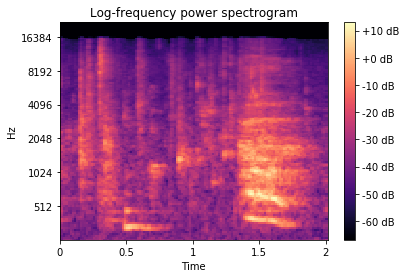

In [12]:
# example
noisy_example_fn = noisy_data_dir_path + '/' + train_noisy.loc[0, 'fname']
x1 = read_as_melspectrogram(Conf, noisy_example_fn, debug_display=True)

mel-spectogram - displays frequency and amplitude visualized over time

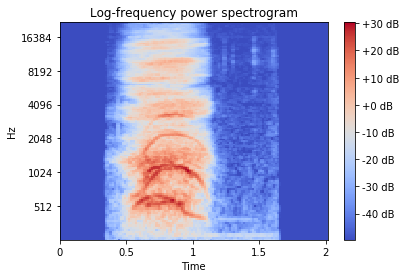

In [13]:
test_example_fn = test_data_dir_path + '/' + test.loc[20, 'fname']
x2 = read_as_melspectrogram(Conf, test_example_fn, debug_display=True)

In [14]:
def mono_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    Xstd = (X - mean) / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Scale to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

def convert_wav_to_image(df, source):
    X = []
    # make loops show a smart progress meter using iterable wrapper, tqdm_notebook
    for i, row in tqdm_notebook(df.iterrows()):
        x = read_as_melspectrogram(Conf, source + '/' + str(row.fname))
        x_color = mono_to_color(x)
        X.append(x_color)
    return X

In [15]:
# Load all the audio as spectogram images in memory
X_train_noisy_images = convert_wav_to_image(train_noisy, source=noisy_data_dir_path)
X_test_images = convert_wav_to_image(test, source=test_data_dir_path)

In [16]:
# Spectogram images are all 3 channel tensors of size 128x128
X_train_noisy_images[0].shape

(128, 128, 3)

In [17]:
import PIL
import random

noisy_file_names = list(train_noisy.fname.values)
test_file_names = list(test.fname.values)

def open_image(fn, file_names, images)->PIL.Image:
    filename = fn.split('/')[-1]
    idx = file_names.index(filename)
    x = PIL.Image.fromarray(images[idx])
    return x

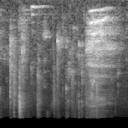

In [18]:
open_image(noisy_example_fn, noisy_file_names, X_train_noisy_images)

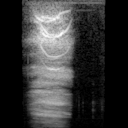

In [19]:
open_image(test_example_fn, test_file_names, X_test_images)

In [20]:
from keras import losses, models, optimizers
from keras.layers import (Input, Dense, Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten, GlobalMaxPool2D, MaxPool2D, concatenate, Activation)
from keras.utils import Sequence, to_categorical
from keras import backend as K
from keras.callbacks import (EarlyStopping, ModelCheckpoint, TensorBoard)
from keras.activations import relu, softmax

COMPLETE_RUN = True

category_group = train_noisy.groupby(['labels']).count()
category_group.columns = ['counts']
print(len(category_group))

category_group.head()

Using TensorFlow backend.


80


,counts
labels,
Accelerating_and_revving_and_vroom,250
Accordion,261
Acoustic_guitar,249
Applause,254
Bark,257


In [23]:
def get_2d_dummy_model(config):
    
    nclass = config.n_classes
    
    inp = Input(shape=(config.dim[0],config.dim[1],config.dim[2]))
    x = GlobalMaxPool2D()(inp)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

def get_2d_conv_model(config):
    
    nclass = config.n_classes
    
    inp = Input(shape=(config.dim[0],config.dim[1],config.dim[2]))
    x = Convolution2D(32, (4,10), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)

    x = Flatten()(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

In [24]:
# The DataGenerator class inherits from keras.utils.Sequence .
# It is useful for preprocessing and feeding the data to a Keras model.

# Note: Sequence are a safer way to do multiprocessing.
# This structure guarantees that the network will only train once on each
# sample per epoch which is not the case with generators.
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

class DataGenerator(Sequence):
    def __init__(self,
                 config,
                 data_dir,
                 list_IDs,
                 file_names,
                 images,
                 labels=None, 
                 batch_size=64,
                 preprocessing_fn=lambda x: x):
        self.config = config
        self.data_dir = data_dir
        self.list_IDs = list_IDs
        self.file_names = file_names
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.preprocessing_fn = preprocessing_fn
        self.on_epoch_end()
        self.dim = self.config.dim

    def __len__(self):
        # Once initialized with a batch_size, DataGenerator computes the number of batches in an epoch.
        # The __len__ method tells Keras how many batches to draw in each epoch.
        return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        # The __getitem__ method takes an index (which is the batch number) and
        # returns a batch of the data (both X and y) after calculating the offset.
        # During test time, only X is returned.
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        return self.__data_generation(list_IDs_temp)

    def on_epoch_end(self):
        # If we want to perform some action after each epoch (like shuffle the data,
        # or increase the proportion of augmented data), we can use the on_epoch_end method.
        self.indexes = np.arange(len(self.list_IDs))

    def __data_generation(self, list_IDs_temp):
        cur_batch_size = len(list_IDs_temp)
        X = np.empty((cur_batch_size, *self.dim))

        input_length = self.config.duration
        for i, ID in enumerate(list_IDs_temp):
            file_path = self.data_dir + '/' + str(ID)
            
            # Read and Resample the audio
            data = open_image(file_path, self.file_names, self.images)
            data = np.expand_dims(data, axis=0)

            X[i] = data

        if self.labels is not None:
            y = np.empty(cur_batch_size, dtype=int)
            for i, ID in enumerate(list_IDs_temp):
                y[i] = self.labels[ID]
            return X, to_categorical(y, num_classes=self.config.n_classes)
        else:
            return X

In [ ]:
test.head()

In [26]:
# List of unique labels
LABELS = list(train_noisy['labels'].unique())

# dict of labels to numerical representation (0-80)
label_idx = {label: i for i, label in enumerate(LABELS)}

# Add a column for integer representatios of labels
_train_noisy = train_noisy.copy().set_index("fname")
_train_noisy["label_idx"] = _train_noisy['labels'].apply(lambda x: label_idx[x])

_test = test.copy().set_index("fname")

# Create numpy array for one hot encoded representation of labels
y_train = to_categorical(_train_noisy.label_idx.astype('str'), num_classes=Conf.n_classes)

if not COMPLETE_RUN:
    _train_noisy = _train_noisy[:2000]
    test = test[:2000]

In [32]:
train_noisy.head(1)

,fname,labels
0,00097e21.wav,Bathtub_(filling_or_washing)


In [33]:
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [34]:
len(train_noisy['fname'])

16566

In [35]:
skf = StratifiedKFold(n_splits=Conf.n_folds)
for i, (train_split, val_split) in enumerate(skf.split(_train_noisy.index, _train_noisy.label_idx)):
    train_set = train_noisy.iloc[train_split]
    print(train_set.sample())
    break

             fname                        labels
8284  6a75d770.wav  Bathtub_(filling_or_washing)


In [36]:
PREDICTION_FOLDER = "predictions_2d_spectogram_conv"
if not os.path.exists(PREDICTION_FOLDER):
    os.mkdir(PREDICTION_FOLDER)
if os.path.exists('logs/' + PREDICTION_FOLDER):
    shutil.rmtree('logs/' + PREDICTION_FOLDER)

# We use from sklearn.model_selection.StratifiedKFold for splitting the trainig data into 10 folds.
skf = StratifiedKFold(n_splits=Conf.n_folds)

for i, (train_split, val_split) in enumerate(skf.split(_train_noisy.index, _train_noisy.label_idx)):
    train_set = _train_noisy.iloc[train_split]
    val_set = _train_noisy.iloc[val_split]
    
    # We use some Keras callbacks to monitor the training.
    # ModelCheckpoint saves the best weight of our model (using validation data).
    # We use this weight to make test predictions.
    checkpoint = ModelCheckpoint('best_%d.h5'%i, monitor='val_loss', verbose=1, save_best_only=True)
    # EarlyStopping stops the training once validation loss ceases to decrease
    early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    # TensorBoard helps us visualize training and validation loss and accuracy.
    tb = TensorBoard(log_dir='./logs/' + PREDICTION_FOLDER + '/fold_%d'%i, write_graph=True)

    callbacks_list = [checkpoint, early, tb]
    print("\nFold: ", i)
    if COMPLETE_RUN:
        model = get_2d_conv_model(Conf)
    else:
        model = get_2d_dummy_model(Conf)

    # We fit the model using DataGenerator for training and validation splits.
    train_generator = DataGenerator(Conf, noisy_data_dir_path, train_set.index, noisy_file_names, X_train_noisy_images, train_set.label_idx, batch_size=64)
    val_generator = DataGenerator(Conf, noisy_data_dir_path, val_set.index, noisy_file_names, X_train_noisy_images, val_set.label_idx, batch_size=64)
    
    history = model.fit_generator(train_generator, callbacks=callbacks_list, validation_data=val_generator,
                                  epochs=Conf.max_epochs, use_multiprocessing=True, max_queue_size=20)
    
    # model.load_weights('../working/best_%d.h5'%i)
    
    # Save train predictions
    train_generator = DataGenerator(Conf, noisy_data_dir_path, _train_noisy.index, noisy_file_names, X_train_noisy_images, batch_size=128)
    predictions = model.predict_generator(train_generator, use_multiprocessing=True, max_queue_size=20, verbose=1)
    
    # We get both training and test predictions and save them as .npy format.
    # We also generate a submission file. For 10-fold CV, the number of prediction files should be 10.
    # We will ensemble these predictions later.
    np.save(PREDICTION_FOLDER + "/train_predictions_%d.npy"%i, predictions)
    
    # Save test predictions
    test_generator = DataGenerator(Conf, test_data_dir_path, _test.index, test_file_names, X_test_images, batch_size=128)
    predictions = model.predict_generator(test_generator, use_multiprocessing=True, max_queue_size=20, verbose=1)
    np.save(PREDICTION_FOLDER + "/test_predictions_%d.npy"%i, predictions)
    
    # Make a submission file
    top_3 = np.array(LABELS)[np.argsort(-predictions, axis=1)[:, :3]]
    predicted_labels = [' '.join(list(x)) for x in top_3]
    _test['label'] = predicted_labels
    _test[['label']].to_csv(PREDICTION_FOLDER + "/predictions_%d.csv"%i)


Fold:  0
Epoch 1/50
233/233 [==============================] - 1084s 5s/step - loss: 4.2183 - acc: 0.0550 - val_loss: 4.0675 - val_acc: 0.0756

Epoch 00001: val_loss improved from inf to 4.06754, saving model to best_0.h5
Epoch 2/50
233/233 [==============================] - 1285s 6s/step - loss: 3.8954 - acc: 0.1134 - val_loss: 3.9347 - val_acc: 0.0962

Epoch 00002: val_loss improved from 4.06754 to 3.93471, saving model to best_0.h5
Epoch 3/50
233/233 [==============================] - 1098s 5s/step - loss: 3.7092 - acc: 0.1593 - val_loss: 3.8084 - val_acc: 0.1246

Epoch 00003: val_loss improved from 3.93471 to 3.80844, saving model to best_0.h5
Epoch 4/50
233/233 [==============================] - 1100s 5s/step - loss: 3.5565 - acc: 0.1970 - val_loss: 3.7023 - val_acc: 0.1488

Epoch 00004: val_loss improved from 3.80844 to 3.70228, saving model to best_0.h5
Epoch 5/50
233/233 [==============================] - 1671s 7s/step - loss: 3.4222 - acc: 0.2295 - val_loss: 3.7095 - val_acc:

233/233 [==============================] - 1065s 5s/step - loss: 3.3131 - acc: 0.2487 - val_loss: 3.5126 - val_acc: 0.1781

Epoch 00006: val_loss improved from 3.73858 to 3.51259, saving model to best_2.h5
Epoch 7/50
233/233 [==============================] - 1066s 5s/step - loss: 3.1928 - acc: 0.2730 - val_loss: 3.5867 - val_acc: 0.1638

Epoch 00007: val_loss did not improve from 3.51259
Epoch 8/50
233/233 [==============================] - 1065s 5s/step - loss: 3.0798 - acc: 0.3032 - val_loss: 3.5677 - val_acc: 0.1739

Epoch 00008: val_loss did not improve from 3.51259
Epoch 9/50
233/233 [==============================] - 1065s 5s/step - loss: 2.9716 - acc: 0.3281 - val_loss: 3.5150 - val_acc: 0.1662

Epoch 00009: val_loss did not improve from 3.51259
Epoch 10/50
233/233 [==============================] - 1065s 5s/step - loss: 2.8564 - acc: 0.3561 - val_loss: 3.7349 - val_acc: 0.1315

Epoch 00010: val_loss did not improve from 3.51259
Epoch 11/50
233/233 [============================


Epoch 00016: val_loss did not improve from 3.30289
Epoch 17/50
233/233 [==============================] - 1066s 5s/step - loss: 2.1210 - acc: 0.5505 - val_loss: 3.3524 - val_acc: 0.2075

Epoch 00017: val_loss did not improve from 3.30289
Epoch 18/50
233/233 [==============================] - 1188s 5s/step - loss: 2.0058 - acc: 0.5803 - val_loss: 3.6394 - val_acc: 0.1569

Epoch 00018: val_loss did not improve from 3.30289
Epoch 19/50
233/233 [==============================] - 1073s 5s/step - loss: 1.8974 - acc: 0.6145 - val_loss: 3.4535 - val_acc: 0.1834

Epoch 00019: val_loss did not improve from 3.30289
9/9 [==============================] - 24s 3s/step

Fold:  5
Epoch 1/50
233/234 [============================>.] - ETA: 4s - loss: 4.1906 - acc: 0.0612Epoch 1/50
Epoch 1/50
234/234 [==============================] - 1078s 5s/step - loss: 4.1895 - acc: 0.0614 - val_loss: 4.0596 - val_acc: 0.0703

Epoch 00001: val_loss improved from inf to 4.05957, saving model to best_5.h5
Epoch 2/50
2

234/234 [==============================] - 1067s 5s/step - loss: 2.2102 - acc: 0.5218 - val_loss: 3.4390 - val_acc: 0.1976

Epoch 00016: val_loss did not improve from 3.32890
Epoch 17/50
234/234 [==============================] - 1066s 5s/step - loss: 2.0999 - acc: 0.5549 - val_loss: 3.3621 - val_acc: 0.2055

Epoch 00017: val_loss did not improve from 3.32890
Epoch 18/50
234/234 [==============================] - 1066s 5s/step - loss: 1.9803 - acc: 0.5919 - val_loss: 3.3431 - val_acc: 0.2122

Epoch 00018: val_loss did not improve from 3.32890
9/9 [==============================] - 24s 3s/step

Fold:  7
Epoch 1/50
234/234 [==============================] - 1068s 5s/step - loss: 4.2234 - acc: 0.0548 - val_loss: 4.0878 - val_acc: 0.0689

Epoch 00001: val_loss improved from inf to 4.08783, saving model to best_7.h5
Epoch 2/50
234/234 [==============================] - 1067s 5s/step - loss: 3.8998 - acc: 0.1175 - val_loss: 3.9171 - val_acc: 0.0896

Epoch 00002: val_loss improved from 4.0878

234/234 [==============================] - 1071s 5s/step - loss: 3.3147 - acc: 0.2443 - val_loss: 4.1116 - val_acc: 0.0655

Epoch 00006: val_loss did not improve from 3.66577
Epoch 7/50
234/234 [==============================] - 1069s 5s/step - loss: 3.2003 - acc: 0.2691 - val_loss: 3.5067 - val_acc: 0.1946

Epoch 00007: val_loss improved from 3.66577 to 3.50673, saving model to best_9.h5
Epoch 8/50
234/234 [==============================] - 1069s 5s/step - loss: 3.0975 - acc: 0.2897 - val_loss: 3.5865 - val_acc: 0.1544

Epoch 00008: val_loss did not improve from 3.50673
Epoch 9/50
234/234 [==============================] - 1067s 5s/step - loss: 2.9868 - acc: 0.3156 - val_loss: 3.4134 - val_acc: 0.1995

Epoch 00009: val_loss improved from 3.50673 to 3.41339, saving model to best_9.h5
Epoch 10/50
234/234 [==============================] - 1071s 5s/step - loss: 2.8836 - acc: 0.3414 - val_loss: 3.6777 - val_acc: 0.1439

Epoch 00010: val_loss did not improve from 3.41339
Epoch 11/50
234/23

In [38]:
# Ensembling 2D Conv Predictions¶

pred_list = []
for i in range(Conf.n_folds):
    pred_list.append(np.load(PREDICTION_FOLDER + "/test_predictions_%d.npy"%i))
prediction = np.ones_like(pred_list[0])
for pred in pred_list:
    prediction = prediction*pred
prediction = prediction**(1./len(pred_list))
# Make a submission file
top_3 = np.array(LABELS)[np.argsort(-prediction, axis=1)[:, :3]]
predicted_labels = [' '.join(list(x)) for x in top_3]
test = pd.read_csv(data_path + '/sample_submission.csv')
test['label'] = predicted_labels
test[['fname', 'label']].to_csv("2d_conv_spectogram_ensembled_submission.csv", index=False)

In [42]:
test[['fname', 'label']].sample(5)

,fname,label
752,2dfd32a3.wav,Male_speech_and_man_speaking Female_singing Ma...
144,08278440.wav,Bark Chirp_and_tweet Sigh
156,08b06642.wav,Buzz Bark Knock
916,37155f3a.wav,Cheering Race_car_and_auto_racing Crowd
794,30ac78a6.wav,Bicycle_bell Harmonica Chirp_and_tweet


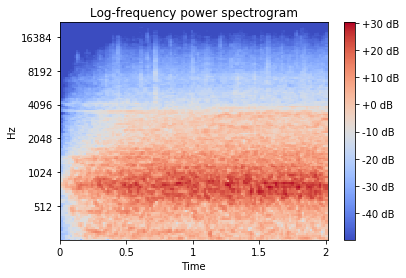

fname                               37155f3a.wav
label    Cheering Race_car_and_auto_racing Crowd
Name: 916, dtype: object


In [59]:
index = 916
test_example_fn = test_data_dir_path + '/' + test.loc[index, 'fname']
xTest = read_as_melspectrogram(Conf, test_example_fn, debug_display=True)
print(test[['fname', 'label']].loc[index])